In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('../images/style_sheet.mplstyle')
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix

import os
import sys
sys.path.append(os.path.join(os.path.abspath(''), '..'))
from utils.transformer import WaveletTransformer

In [2]:
X_train = np.load('../data/X_train.npy')
y_train = np.load('../data/y_train.npy')
groups_train = np.load('../data/groups_train.npy')
severities_train = np.load('../data/severities_train.npy')

In [3]:
pipeline = Pipeline([
    ('wavelet_transformer', WaveletTransformer(w_list=[65, 454, 1232], n_samples=100, n_frequencies=20)),
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=9)),
    ('svm', SVC(probability=True, kernel='rbf', gamma=5.156e-4, C=61.82))
])

pipeline.fit(X_train, y_train);

In [4]:
y_pred_train = pipeline.predict(X_train)
y_pred_proba_train = pipeline.predict_proba(X_train)

In [5]:
X_test = np.load('../data/X_test.npy')
y_test = np.load('../data/y_test.npy')
groups_test = np.load('../data/groups_test.npy')
severities_test = np.load('../data/severities_test.npy')

In [6]:
y_pred_test = pipeline.predict(X_test)
y_pred_proba_test = pipeline.predict_proba(X_test)

In [7]:
X_cvd = np.load('../data/X_cvd.npy')
y_cvd = np.load('../data/y_cvd.npy')
groups_cvd = np.load('../data/groups_cvd.npy')

X_cvd = X_cvd[y_cvd == 0]
groups_cvd = groups_cvd[y_cvd == 0]
y_cvd = np.abs(y_cvd[y_cvd == 0] - 1)

In [8]:
y_pred_cvd = pipeline.predict(X_cvd)
y_pred_proba_cvd = pipeline.predict_proba(X_cvd)

In [9]:
y_pred_no_cvd =  y_pred_test[y_test == 0]
y_pred_proba_no_cvd = y_pred_proba_test[y_test == 0]

y_combined = np.concatenate((np.ones(y_pred_cvd.shape[0]), np.zeros(y_pred_no_cvd.shape[0])))
y_pred_combined = np.concatenate((y_pred_cvd, y_pred_no_cvd))
y_pred_proba_combined = np.concatenate((y_pred_proba_cvd[:, 1], y_pred_proba_no_cvd[:, 1]))

Accuracy: 78.75%
Recall: 76.92%
Precision: 78.95%
F1: 77.92%
AUC ROC: 90.12%


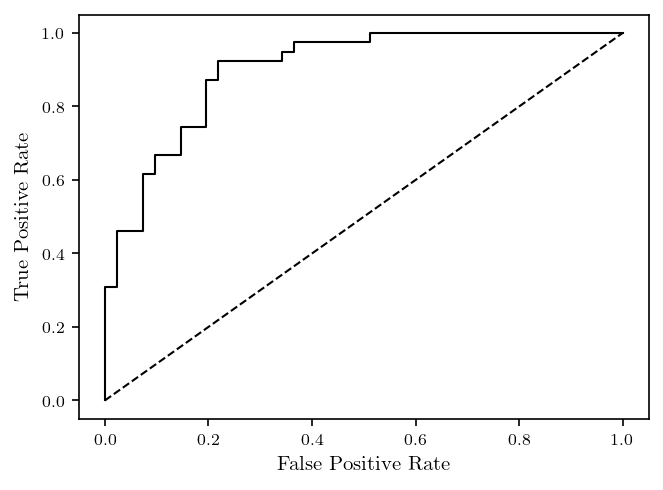

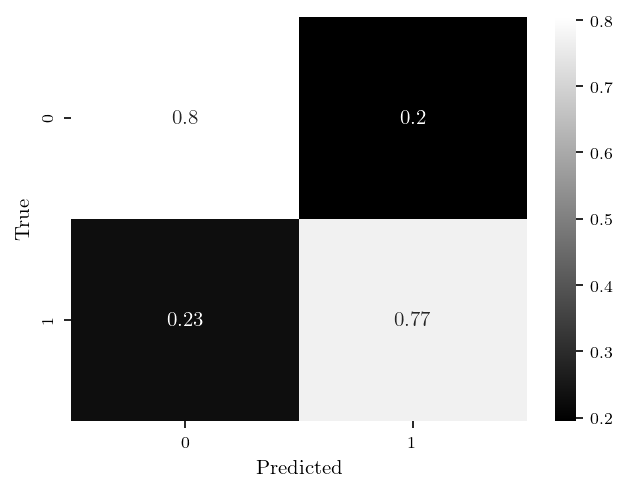

In [10]:
accuracy = np.mean(y_pred_combined == y_combined)
print(f'Accuracy: {accuracy:.2%}')

recall = np.sum(np.logical_and(y_combined, y_pred_combined)) / np.sum(y_combined)
print(f'Recall: {recall:.2%}')

precision = np.sum(np.logical_and(y_combined, y_pred_combined)) / np.sum(y_pred_combined)
print(f'Precision: {precision:.2%}')

f1 = 2 * precision * recall / (precision + recall)
print(f'F1: {f1:.2%}')

auc_roc = roc_auc_score(y_combined, y_pred_proba_combined)
print(f'AUC ROC: {auc_roc:.2%}')

fpr, tpr, thresholds = roc_curve(y_combined, y_pred_proba_combined)
plt.plot(fpr, tpr, color='black')
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.savefig('../images/roc_rbf.pdf', format='pdf')
plt.show()

conf_matrix = confusion_matrix(y_combined, y_pred_combined, normalize='true')
sns.heatmap(conf_matrix, annot=True, cmap='grey')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig('../images/confusion_matrix_rbf.pdf', format='pdf')
plt.show()